<br>

# 🖼️ **IMAGE CLASSIFICATION** 🖼️ 

**NEURAL NETWORKS**

## **INDEX**



- **STEP 1: PROBLEM DEFINITION AND DATA COLLECTION**
- **STEP 2: MODEL AND ARCHITECTURE**
- **STEP 3: MODEL TRAINNG**
- **STEP 4: MODEL OPTIMIZATION**
- **STEP 5: MODEL EVALUATION**

<br>

<br>

<br>

# **STEP 1: PROBLEM DEFINITION AND DATA COLLECTION**

- 1.1. Problem Definition
- 1.2. Library Importing
- 1.3. Visualize the Input Information

<br>

**1.1. PROBLEM DEFINITION**

This project aims to develop a robust **image classification system** capable of distinguishing between `dog` and `cat` photos with high accuracy. The dataset for this task originates from a collaboration between Petfinder.com and Microsoft, containing a subset of 25,000 dog and cat images drawn from a much larger collection of 3 million manually annotated photos.

**Background**

- The dataset was originally used as a CAPTCHA named "Asirra," designed to differentiate humans from bots.
- User studies indicated a 99.6% success rate for humans within 30 seconds, while computers were expected to have a significantly lower success rate.
- However, a 2007 paper demonstrated an SVM-based approach achieving 80% accuracy, rendering "Asirra" unsuitable for CAPTCHA purposes.

**OUR OBJETIVE**

To build an image classification model that surpasses the state-of-the-art performance of 80% accuracy and reliably identifies dogs and cats within the provided dataset.

<br>

**1.2. LIBRARY IMPORTING**

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import shutil 
import matplotlib.pyplot as plt



from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.layers import Flatten, Dense


<br>

**1.3. VISUALIZE THE INPUT IMFORMATION**

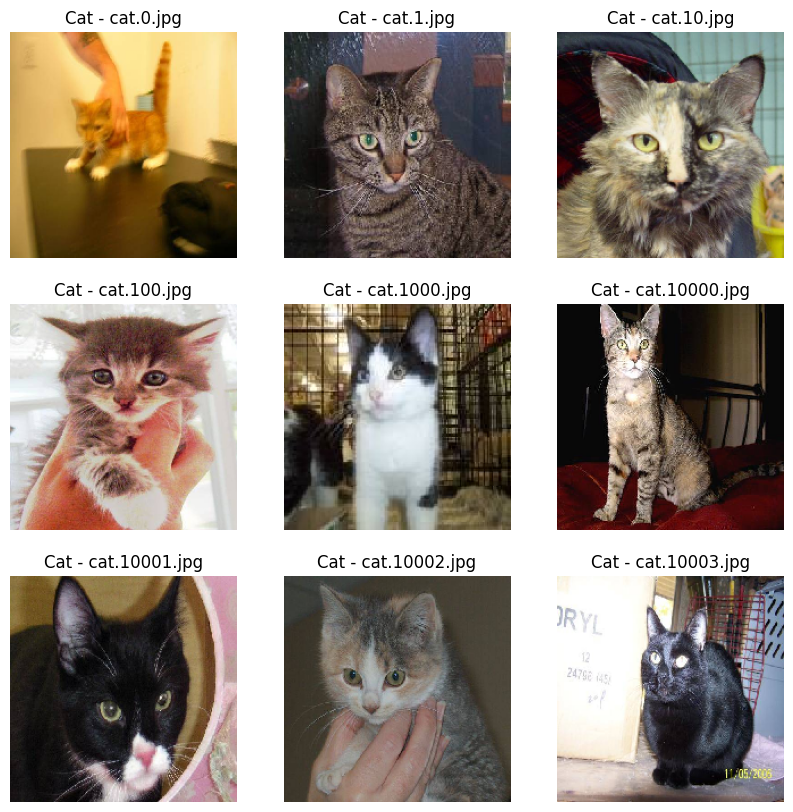

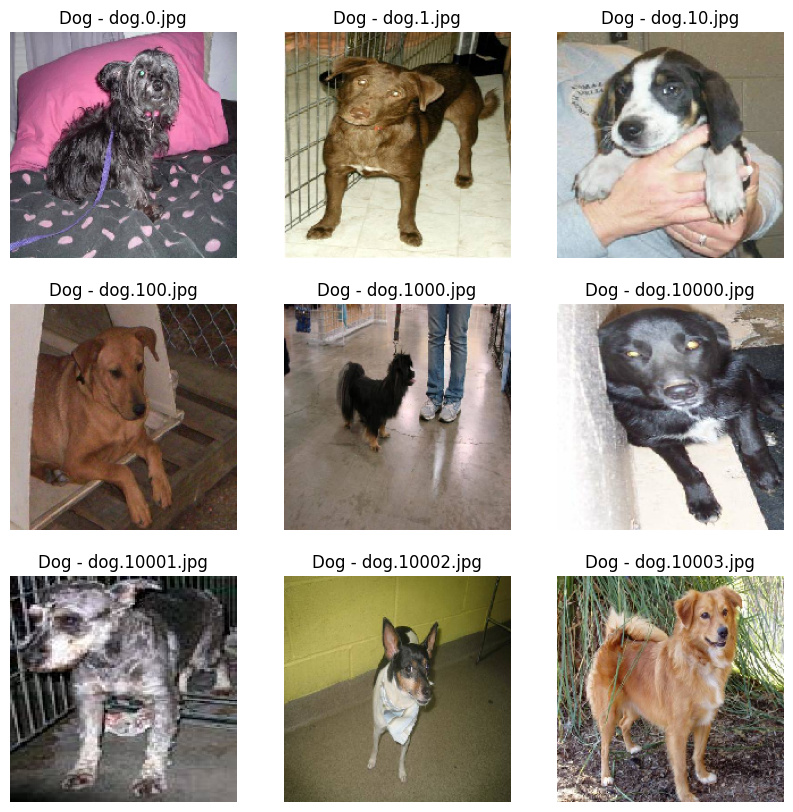

In [12]:
# Function to load images from a folder and classify them
def load_images_from_folder(folder, target_size=(200, 200), count=9, label_filter=None):
    images = []
    filenames = []
    loaded_count = 0

    # Verify if the directory exists
    if not os.path.exists(folder):
        print(f"La carpeta {folder} no existe.")
        return np.array(images), filenames

    for filename in os.listdir(folder):
        # Complete file location
        img_path = os.path.join(folder, filename)

        # Ignore folders
        if not os.path.isfile(img_path):
            continue

        # Verify the filter by category (if applicable)
        if label_filter and label_filter not in filename.lower():
            continue

        try:
            # Load and process the image
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0  # Normalización
            images.append(img_array)
            filenames.append(filename)
            loaded_count += 1

            # Stop when the required images have been loaded
            if loaded_count >= count:
                break
        except Exception as e:
            print(f"Error loading the image {img_path}: {e}")

    if not images:
        print(f"No images were found with the filter '{label_filter}' en {folder}.")
    return np.array(images), filenames

# Image grid display function
def plot_images(images, filenames, label):
    if len(images) == 0:
        print(f"No images available to show in {label}.")
        return
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(3, 3, i + 1)  # To create a 3x3 grid
        plt.imshow(img)  # Show the image
        plt.title(f"{label} - {filenames[i]}")
        plt.axis("off")  # Hide the axes
    plt.show()

# Folder path
data_dir = r"C:\Users\Jen\Desktop\REPOSITORIOS\IMAGE-CLASSIFIER-neural-networks\data\raw\processed\train"

# Upload and display 'cat' images
cat_images, cat_filenames = load_images_from_folder(
    os.path.join(data_dir, "cat"),  # Location of the 'cat' folder
    target_size=(200, 200),
    count=9
)
plot_images(cat_images, cat_filenames, "Cat")

# Upload and display 'dog' images
dog_images, dog_filenames = load_images_from_folder(
    os.path.join(data_dir, "dog"),  # Location of the 'dog' folder
    target_size=(200, 200),
    count=9
)
plot_images(dog_images, dog_filenames, "Dog")


<br>

<br>

- Now we are going to organize a set of images into two separate subdirectories ("cat" and "dog") based on whether their filenames contain the words "cat" or "dog". This is a common step in image classification tasks, where images need to be labeled and separated into their respective classes for training a machine learning model.

In [13]:
# Path to the 'train' folder
train_dir = r"C:\Users\Jen\Desktop\REPOSITORIOS\IMAGE-CLASSIFIER-neural-networks\data\raw\processed\train"

# Create subdirectories for cats and dogs images
cat_dir = os.path.join(train_dir, "cat")
dog_dir = os.path.join(train_dir, "dog")
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Moves images to subdirectories
for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)
    if os.path.isfile(file_path):  # Verify that it is a file
        if "cat" in filename.lower():  # If the name contains "cat"
            shutil.move(file_path, os.path.join(cat_dir, filename))
        elif "dog" in filename.lower():  # If the name contains "dog"
            shutil.move(file_path, os.path.join(dog_dir, filename))

print("The 'train' images are neatly structured.")


The 'train' images are neatly structured.


<br>

Let's prepare the image data for a deep learning model by:

- Reading images from a specified directory.
- Applying data augmentation techniques to increase the diversity of the training data.
- Creating generators to efficiently load batches of images during training and validation.
- Verifying the shape of a batch of images and labels to ensure correct data loading.

In [14]:
#Path to the training directory
train_dir = r"C:\Users\Jen\Desktop\REPOSITORIOS\IMAGE-CLASSIFIER-neural-networks\data\raw\processed\train"

# Create data generators with training and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalization
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Threshold transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Horizontal flip
    fill_mode='nearest',      # Filling missing pixels
    validation_split=0.2      # Split 80/20 for training and validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),  # Fixed image size
    batch_size=32,           # Batch size
    class_mode='binary',     # Binary classification
    subset='training'        # Training set
)

# Generador para validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    subset='validation'      # Validation Set Generator
)

#  Verify a training batch
batch_images, batch_labels = next(train_generator)
print(f"Batch size of images: {batch_images.shape}")  # It should be a 4-dimensional array with shape (32, 200, 200, 3)
print(f"Tamaño del lote de etiquetas: {batch_labels.shape}")  #  It should be (32,)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Batch size of images: (32, 200, 200, 3)
Tamaño del lote de etiquetas: (32,)


<br>

# **STEP 2. MODEL AND ARCHITECTURE**


In [15]:
# Load the pretrained VGG16 base model without the top layers
# Set input shape to (200, 200, 3) to match our image size
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

# Build a new model on top of the frozen VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())  # Flatten the output of the base model
model.add(Dense(4096, activation='relu'))  # First fully connected layer
model.add(Dense(4096, activation='relu'))  # Second fully connected layer
model.add(Dense(1, activation='sigmoid'))   # Output layer for binary classification

# Compile the model using Adam optimizer with a low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    75,501,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,001,665 (408.18 MB)

 Trainable params: 92,286,977 (352.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Explanation:**

- **Using Pretrained VGG16:**
The pretrained VGG16 model **IS LOADED WITHOUT INCLUDING TOP** (the classification layers) and the input shape is set to (200, 200, 3) to match the defined image size.

- **Freezing Base Layers:**
The model base is frozen (by `setting base_model.trainable = False`) **to prevent its weights from being updated during training, allowing it to focus on learning the new top layers for binary classification.**

**WHY?**

**The decision to load VGG16 without the top** is based on taking advantage of transfer learning.

1. **Transfer Learning:**
VGG16 has been trained on the ImageNet dataset, which means its convolutional layers have learned to detect general features (edges, textures, patterns) that are useful for many vision tasks. **By removing the top** (the classification layers specific to ImageNet), we reuse these general features and **adapt them to our problem** (binary classification of cats and dogs).

2. **Adaptation to the specific task:**
**The original** top of **VGG16 is designed to classify 1000 classes**, which is **not suitable for our case of only two classes**. By not including these layers, we can add our own dense layers (for example, two layers of 4096 neurons and a final layer with sigmoid activation) that are adapted to binary classification.

3. **Compatibility with image size:**
Since it has been decided to work with 200x200 images to make training lighter, it is necessary to adjust the `input_shape` of the model to (200, 200, 3). This ensures that the model processes images of that size without problems, while maintaining consistency throughout the preprocessing and training pipeline.

In summary, this decision allows us to efficiently use a robust and pre-trained model (VGG16) to extract features from images, adapting it to specific problems and resource limitations (working with 200x200 images).

<br>

<br>

# **STEP 3: MODEL TRAINING**

- 3.1. Data augmentation and validation split
- 3.2. Data Generators
- 3.3. Callbacks Setup
- 3.4. Model Training


<br>

**1.1. DATA AUGMENTATION AND VALIDATION SPLIT**

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation and Validation Split
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0,1]
    rotation_range=20,       # Random rotations
    width_shift_range=0.2,   # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest',     # Fill missing pixels after transformation
    validation_split=0.2     # Reserve 20% of data for validation
)


<br>

**3.2. DATA GENERATORS**

In [17]:
# Define the path to the training directory
train_dir = r"C:\Users\Jen\Desktop\REPOSITORIOS\IMAGE-CLASSIFIER-neural-networks\data\raw\processed\train"

# Create the training generator using the 'training' subset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),  # Resize images to 200x200 pixels
    batch_size=32,
    class_mode='binary',     # Binary classification (cat vs. dog)
    subset='training'
)

# Create the validation generator using the 'validation' subset
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),  # Resize images to 200x200 pixels
    batch_size=32,
    class_mode='binary',     # Binary classification (cat vs. dog)
    subset='validation'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


<br>

**3.3. CALLBACKS SETUP**

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Setup callbacks to save the best model and stop training early if validation loss doesn't improve
checkpoint = ModelCheckpoint("models/best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)


<br>

**3.4. MODEL TRAINING**

In [19]:
# Train the model using the training and validation generators along with the callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Increase epochs for robust training
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stop]
)

c:\Users\Jen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8075 - loss: 0.4369
Epoch 1: val_accuracy improved from -inf to 0.88900, saving model to models/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 6929s 11s/step - accuracy: 0.8076 - loss: 0.4367 - val_accuracy: 0.8890 - val_loss: 0.2683
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8832 - loss: 0.2671
Epoch 2: val_accuracy improved from 0.88900 to 0.90160, saving model to models/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 6190s 10s/step - accuracy: 0.8832 - loss: 0.2671 - val_accuracy: 0.9016 - val_loss: 0.2287
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8949 - loss: 0.2431
Epoch 3: val_accuracy did not improve from 0.90160
625/625 ━━━━━━━━━━━━━━━━━━━━ 5681s 9s/step - accuracy: 0.8949 - loss: 0.2430 - val_accuracy: 0.8974 - val_loss: 0.2301
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8989 - loss: 0.2329
Epoch 4: val_accuracy improved from 0.90160 to 0.90680, savin

<br>

# **STEP 4: MODEL OPTIMIZATION**



- 4.1. Plot Accuracy & Loss Graphs 📊 → Identify any overfitting trends
- 4.2. Loading the best model

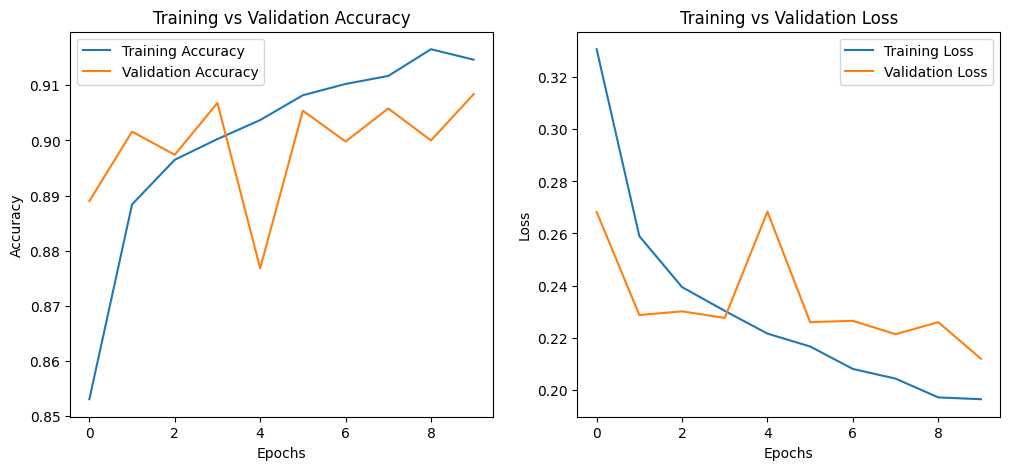

In [ ]:
# Function to plot training history
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')

    plt.show()

# Run this function after training
plot_training_history(history)


**ANALYSIS OF TRAINING & VALIDATION METRICS:**

**ACCURACY PLOT (Left Graph):**

- Training accuracy improves consistently.
- Validation accuracy fluctuates but follows an upward trend, ending close to training accuracy.
- Some sharp drops in validation accuracy indicate possible instability.

**LOSS PLOT (Right Graph):**
- Training loss steadily decreases → good learning process.
- Validation loss fluctuates but does not significantly diverge → mild overfitting is present.
- Peaks in validation loss align with dips in validation accuracy → instability.

<br>

**4.2. LOADING THE BEST MODEL**

In [21]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
best_model = load_model("models/best_model.keras")

# Confirm the model structure
best_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    75,501,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,575,621 (1.09 GB)

 Trainable params: 92,286,977 (352.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 184,573,956 (704.09 MB)

<br>

<br>

# **STEP 5: MODEL EVALUATION**

- 5.1. Model Evaluation on Validation/Test set
- 5.2: Make predictions on new images


<br>

**5.1. MODEL EVALUATION ON VALIDATION/TEST SET**

In [22]:
# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(validation_generator)

# Print final results
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1147s 7s/step - accuracy: 0.9104 - loss: 0.2071
Validation Accuracy: 0.9078
Validation Loss: 0.2140


**FINAL MODEL EVALUATION RESULTS:**

- ✅ Validation Accuracy: 90.78%
- ✅ Validation Loss: 0.2140

KEY TAKEAWAYS:

- The model maintains a **high validation accuracy (90.78%)**, confirming **good generalization**.
- **Validation loss is low (0.2140)**, meaning the model isn’t overfitting significantly.
- The results are **consistent with training metrics**, which is a good sign.


<br>

**5.2 MAKE PREDICTIONS ON NEW IMAGES**

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to preprocess an image for the model
def preprocess_image(img_path, target_size=(200, 200)):
    # Load the image and resize it
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert to an array and normalize
    img_array = image.img_to_array(img) / 255.0  # Scale pixel values to [0,1]
    
    # Expand dimensions to match the model's input shape (batch of 1)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array, img  # Return both the processed array and the original image


In [39]:
# Function to predict if the image is a cat or a dog
def predict_image(model, img_path):
    # Preprocess the image
    img_array, original_img = preprocess_image(img_path)

    # Make the prediction
    prediction = model.predict(img_array)[0][0]  # Extract probability from the output

    # Interpret the result
    label = "Dog 🐶" if prediction >= 0.5 else "Cat 🐱"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

    # Display the image and result
    plt.imshow(original_img)
    plt.axis("off")
    plt.title(f"Prediction: {label} ({confidence:.2%} confidence)")
    plt.show()
    
    return label, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


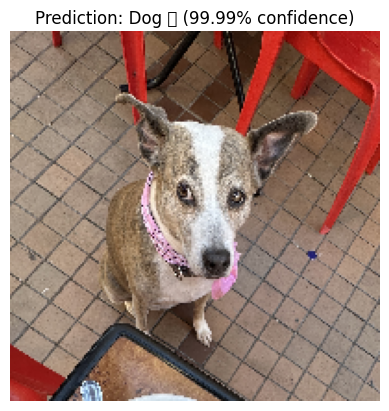

🔮PREDICTION🔮: Dog 🐶 with 99.99% confidence 


In [51]:
# Example: Provide the path to an external image
img_path = r"C:\Users\Jen\Desktop\REPOSITORIOS\IMAGE-CLASSIFIER-neural-networks\test_images\Niki.jpg"
# Predict and display the result
label, confidence = predict_image(best_model, img_path)
print(f"🔮PREDICTION🔮: {label} with {confidence:.2%} confidence ")